# CatBoost Starter for Brain Comp
EEGの差分の集計特徴量を用いたNotebook。
    - ver1: CV 1.01, LB 0.81

### Version Notes
- Version 1 - EEGの各計測場所の、20秒の時間窓のmean, min, max, std, max-minを特徴量とした

# Load Libraries

In [1]:
import os, gc
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt

VER = 1

# Load Train Data

In [2]:
df_train = pl.read_csv('../input/hms-harmful-brain-activity-classification/train.csv')
TARGETS = df_train.columns[-6:]
print('Train shape:', df_train.shape )
print('Targets', list(TARGETS))
df_train.head()

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
i64,i64,f64,i64,i64,f64,i64,i64,str,i64,i64,i64,i64,i64,i64
1628180742,0,0.0,353733,0,0.0,127492639,42516,"""Seizure""",3,0,0,0,0,0
1628180742,1,6.0,353733,1,6.0,3887563113,42516,"""Seizure""",3,0,0,0,0,0
1628180742,2,8.0,353733,2,8.0,1142670488,42516,"""Seizure""",3,0,0,0,0,0
1628180742,3,18.0,353733,3,18.0,2718991173,42516,"""Seizure""",3,0,0,0,0,0
1628180742,4,24.0,353733,4,24.0,3080632009,42516,"""Seizure""",3,0,0,0,0,0


# Create Multiple Eeg Id Train Data
データの説明[here][1]には、テストデータには、同じ `eeg_id` からの複数の crop は含まれていないと記載されている。

今回は、同じeeg_idの複数のeeg_sub_idを用いる。
その後、以下の列をdropしてから学習する

- eeg_id, eeg_sub_id, eeg_label_offset_seconds
- spectrogram_id, spectrogram_sub_id, spectrogram_label_offset_seconds
- label_id

[1]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467021

In [3]:
# 各vote列の合計
df_train = df_train.with_columns(
    (pl.col('seizure_vote') + pl.col('lpd_vote') + pl.col('gpd_vote') + pl.col('lrda_vote') + pl.col('grda_vote') + pl.col('other_vote')).alias('vote_sum')
)

# 各vote列の正規化
df_train = df_train.with_columns(
    (pl.col('seizure_vote') / pl.col('vote_sum')).alias('seizure_vote'),
    (pl.col('lpd_vote') / pl.col('vote_sum')).alias('lpd_vote'),
    (pl.col('gpd_vote') / pl.col('vote_sum')).alias('gpd_vote'),
    (pl.col('lrda_vote') / pl.col('vote_sum')).alias('lrda_vote'),
    (pl.col('grda_vote') / pl.col('vote_sum')).alias('grda_vote'),
    (pl.col('other_vote') / pl.col('vote_sum')).alias('other_vote'),
)
df_train = df_train.drop('sum')

# Feature Engineer


CatBoostモデルに入れる特徴量を作成する。


In [4]:
PATH = '../input/hms-harmful-brain-activity-classification/train_eegs/'
files = os.listdir(PATH)
print(f'There are {len(files)} eeg parquet files')

all_eegs = {}
temp = pl.DataFrame()
for i, f in enumerate(files):
    if i%100 == 0: print(i, ', ', end = '')
    
    if i%5 ==3:
    # if (i < 1) or (eeg_id == 568657):
        temp_eeg = pl.read_parquet(f'{PATH}{f}')
        eeg_id = int(f.split('.')[0])
    

        # train データと、EEGデータにおける部分サンプルを対応させるための時間のキーをつくる
        # https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/468010
        
        # ex.
        # df_trainにおける eeg_label_offset_seconds = 0秒のとき
        # eeg全体における[0秒, 50秒]の50秒分の部分サンプルに対応する

        # df_trainの各行は、EEGの部分サンプル[T-25, T+25]の範囲に対応する
        # eeg_label_offset_secondsはその最初の時刻 T-25に等しい
        temp_offset = df_train.filter(pl.col("eeg_id") == eeg_id).select(["eeg_label_offset_seconds"]).to_series().to_list()

        
        # eegデータにおける、計測開始から各行までの秒数 seconds_eeg
        t = 1/200         # EEGのサンプリング周波数は200Hzなので、1行は1/200秒ごとの計測値を表す  
        seconds = [i*t for i in range(len(temp_eeg))]
        temp_eeg = temp_eeg.with_columns(pl.Series(seconds).alias("seconds_eeg")) 
        
        # eegデータにおける計測時刻 seconds_eeg から25秒引いたときの時刻 seconds_eeg_offset
        # = df_trainにおけるeeg_label_offset_seconds
        temp_eeg = temp_eeg.with_columns((pl.col("seconds_eeg") - 25).alias("seconds_eeg_offset"))


        # 差分特徴量を作る
        temp_eeg = temp_eeg.with_columns(
            (pl.col("Fp1") - pl.col("T3")).alias("LL_Fp1-T3"),
            (pl.col("T3") - pl.col("O1")).alias("LL_T3-O1"),
            (pl.col("Fp1") - pl.col("C3")).alias("LP_Fp1-C3"),
            (pl.col("C3") - pl.col("O1")).alias("LP_C3-O1"),
            (pl.col("Fp2") - pl.col("C4")).alias("RP_Fp2-C4"),
            (pl.col("C4") - pl.col("O2")).alias("RP_C4-O2"),
            (pl.col("Fp2") - pl.col("T4")).alias("RR_Fp2-T4"),
            (pl.col("T4") - pl.col("O2")).alias("RR_T4-O2"),
        )

        # 差分特徴量の集計特徴量をつくる
        window = 4000 # 20秒窓 (20秒 / 1レコード1/200秒 = 4000レコード)
        temp_eeg = temp_eeg.with_columns(
            # LL: Fp1 - T3
            pl.col("LL_Fp1-T3").rolling_mean(window_size=window).alias("mean20s_LL_Fp1-T3"),
            pl.col("LL_Fp1-T3").rolling_max(window_size=window).alias("min20s_LL_Fp1-T3"),
            pl.col("LL_Fp1-T3").rolling_min(window_size=window).alias("max20s_LL_Fp1-T3"),
            pl.col("LL_Fp1-T3").rolling_std(window_size=window).alias("std20s_LL_Fp1-T3"),
            (pl.col("LL_Fp1-T3").rolling_max(window_size=window) - pl.col("LL_Fp1-T3").rolling_min(window_size=window)).alias("max-min_20s_LL_Fp1-T3"),

            # LL: Fp1 - T3
            pl.col("LL_T3-O1").rolling_mean(window_size=window).alias("mean20s_LL_T3-O1"),
            pl.col("LL_T3-O1").rolling_max(window_size=window).alias("min20s_LL_T3-O1"),
            pl.col("LL_T3-O1").rolling_min(window_size=window).alias("max20s_LL_T3-O1"),
            pl.col("LL_T3-O1").rolling_std(window_size=window).alias("std20s_LL_T3-O1"),
            (pl.col("LL_T3-O1").rolling_max(window_size=window) - pl.col("LL_T3-O1").rolling_min(window_size=window)).alias("max-min_20s_LL_T3-O1"),


            # LP: Fp1 - C3
            pl.col("LP_Fp1-C3").rolling_mean(window_size=window).alias("mean20s_LP_Fp1-C3"),
            pl.col("LP_Fp1-C3").rolling_max(window_size=window).alias("min20s_LP_Fp1-C3"),
            pl.col("LP_Fp1-C3").rolling_min(window_size=window).alias("max20s_LP_Fp1-C3"),
            pl.col("LP_Fp1-C3").rolling_std(window_size=window).alias("std20s_LP_Fp1-C3"),
            (pl.col("LP_Fp1-C3").rolling_max(window_size=window) - pl.col("LP_Fp1-C3").rolling_min(window_size=window)).alias("max-min_20s_LP_Fp1-C3"),

            # LP: C3 - O1
            pl.col("LP_C3-O1").rolling_mean(window_size=window).alias("mean20s_LP_C3-O1"),
            pl.col("LP_C3-O1").rolling_max(window_size=window).alias("min20s_LP_C3-O1"),
            pl.col("LP_C3-O1").rolling_min(window_size=window).alias("max20s_LP_C3-O1"),
            pl.col("LP_C3-O1").rolling_std(window_size=window).alias("std20s_LP_C3-O1"),
            (pl.col("LP_C3-O1").rolling_max(window_size=window) - pl.col("LP_C3-O1").rolling_min(window_size=window)).alias("max-min_20s_LP_C3-O1"),


            # RP: Fp1 - C4
            pl.col("RP_Fp2-C4").rolling_mean(window_size=window).alias("mean20s_RP_Fp2-C4"),
            pl.col("RP_Fp2-C4").rolling_max(window_size=window).alias("min20s_RP_Fp2-C4"),
            pl.col("RP_Fp2-C4").rolling_min(window_size=window).alias("max20s_RP_Fp2-C4"),
            pl.col("RP_Fp2-C4").rolling_std(window_size=window).alias("std20s_RP_Fp2-C4"),
            (pl.col("RP_Fp2-C4").rolling_max(window_size=window) - pl.col("RP_Fp2-C4").rolling_min(window_size=window)).alias("max-min_20s_RP_Fp2-C4"),

            # RP: C4 - O2
            pl.col("RP_C4-O2").rolling_mean(window_size=window).alias("mean20s_RP_C4-O2"),
            pl.col("RP_C4-O2").rolling_max(window_size=window).alias("min20s_RP_C4-O2"),
            pl.col("RP_C4-O2").rolling_min(window_size=window).alias("max20s_RP_C4-O2"),
            pl.col("RP_C4-O2").rolling_std(window_size=window).alias("std20s_RP_C4-O2"),
            (pl.col("RP_C4-O2").rolling_max(window_size=window) - pl.col("RP_C4-O2").rolling_min(window_size=window)).alias("max-min_20s_RP_C4-O2"),


            # RR: Fp2 - T4
            pl.col("RR_Fp2-T4").rolling_mean(window_size=window).alias("mean20s_RR_Fp2-T4"),
            pl.col("RR_Fp2-T4").rolling_max(window_size=window).alias("min20s_RR_Fp2-T4"),
            pl.col("RR_Fp2-T4").rolling_min(window_size=window).alias("max20s_RR_Fp2-T4"),
            pl.col("RR_Fp2-T4").rolling_std(window_size=window).alias("std20s_RR_Fp2-T4"),
            (pl.col("RR_Fp2-T4").rolling_max(window_size=window) - pl.col("RR_Fp2-T4").rolling_min(window_size=window)).alias("max-min_20s_RR_Fp2-T4"),

            # RR: T4 - O2
            pl.col("RR_T4-O2").rolling_mean(window_size=window).alias("mean20s_RR_T4-O2"),
            pl.col("RR_T4-O2").rolling_max(window_size=window).alias("min20s_RR_T4-O2"),
            pl.col("RR_T4-O2").rolling_min(window_size=window).alias("max20s_RR_T4-O2"),
            pl.col("RR_T4-O2").rolling_std(window_size=window).alias("std20s_RR_T4-O2"),
            (pl.col("RR_T4-O2").rolling_max(window_size=window) - pl.col("RR_T4-O2").rolling_min(window_size=window)).alias("max-min_20s_RR_T4-O2"),
        )



        # 集計特徴量とEKG以外drop
        temp_eeg = temp_eeg.drop(['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2',
                                  'LL_Fp1-T3', 'LL_T3-O1', 'LP_Fp1-C3', 'LP_C3-O1', 'RP_Fp2-C4', 'RP_C4-O2', 'RR_Fp2-T4', 'RR_T4-O2',])
        
        # seconds_eeg_offsetが、eeg_label_offset_secondsのリストtemp_offsetに含まれるレコードのみ抽出
        temp_eeg = temp_eeg.filter(pl.col("seconds_eeg_offset").is_in(temp_offset))

        # eeg_id を追加
        temp_eeg = temp_eeg.with_columns(pl.lit(str(eeg_id)).alias("eeg_id"))

        # 全ての
        temp = pl.concat([temp, temp_eeg], how = 'vertical')

    else:
        continue
        

There are 17300 eeg parquet files
0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 1600 , 1700 , 1800 , 1900 , 2000 , 2100 , 2200 , 2300 , 2400 , 2500 , 2600 , 2700 , 2800 , 2900 , 3000 , 3100 , 3200 , 3300 , 3400 , 3500 , 3600 , 3700 , 3800 , 3900 , 4000 , 4100 , 4200 , 4300 , 4400 , 4500 , 4600 , 4700 , 4800 , 4900 , 5000 , 5100 , 5200 , 5300 , 5400 , 5500 , 5600 , 5700 , 5800 , 5900 , 6000 , 6100 , 6200 , 6300 , 6400 , 6500 , 6600 , 6700 , 6800 , 6900 , 7000 , 7100 , 7200 , 7300 , 7400 , 7500 , 7600 , 7700 , 7800 , 7900 , 8000 , 8100 , 8200 , 8300 , 8400 , 8500 , 8600 , 8700 , 8800 , 8900 , 9000 , 9100 , 9200 , 9300 , 9400 , 9500 , 9600 , 9700 , 9800 , 9900 , 10000 , 10100 , 10200 , 10300 , 10400 , 10500 , 10600 , 10700 , 10800 , 10900 , 11000 , 11100 , 11200 , 11300 , 11400 , 11500 , 11600 , 11700 , 11800 , 11900 , 12000 , 12100 , 12200 , 12300 , 12400 , 12500 , 12600 , 12700 , 12800 , 12900 , 13000 , 13100 , 13200 , 13300 , 13400 

In [5]:
# trainデータとjoinするために型変換
temp = temp.with_columns(pl.col("eeg_id").cast(pl.Int64).alias("eeg_id"))
temp.head()

# 動作確認のため、特徴量を作ったeeg_idに限定
list_eeg = temp.select(['eeg_id']).to_series().to_list()
df_train = df_train.filter(pl.col("eeg_id").is_in(list_eeg))

# trainデータとjoin
df_train = df_train.join(temp, left_on = ["eeg_id", "eeg_label_offset_seconds"], right_on = ["eeg_id", "seconds_eeg_offset"], how = "left")

In [6]:
# expert_consensus列をtarget列とする
df_train = df_train.rename({"expert_consensus": "target"})
df_train.head()

eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,target,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,vote_sum,EKG,seconds_eeg,mean20s_LL_Fp1-T3,min20s_LL_Fp1-T3,max20s_LL_Fp1-T3,std20s_LL_Fp1-T3,max-min_20s_LL_Fp1-T3,mean20s_LL_T3-O1,min20s_LL_T3-O1,max20s_LL_T3-O1,std20s_LL_T3-O1,max-min_20s_LL_T3-O1,mean20s_LP_Fp1-C3,min20s_LP_Fp1-C3,max20s_LP_Fp1-C3,std20s_LP_Fp1-C3,max-min_20s_LP_Fp1-C3,mean20s_LP_C3-O1,min20s_LP_C3-O1,max20s_LP_C3-O1,std20s_LP_C3-O1,max-min_20s_LP_C3-O1,mean20s_RP_Fp2-C4,min20s_RP_Fp2-C4,max20s_RP_Fp2-C4,std20s_RP_Fp2-C4,max-min_20s_RP_Fp2-C4,mean20s_RP_C4-O2,min20s_RP_C4-O2,max20s_RP_C4-O2,std20s_RP_C4-O2,max-min_20s_RP_C4-O2,mean20s_RR_Fp2-T4,min20s_RR_Fp2-T4,max20s_RR_Fp2-T4,std20s_RR_Fp2-T4,max-min_20s_RR_Fp2-T4,mean20s_RR_T4-O2,min20s_RR_T4-O2,max20s_RR_T4-O2,std20s_RR_T4-O2,max-min_20s_RR_T4-O2
i64,i64,f64,i64,i64,f64,i64,i64,str,f64,f64,f64,f64,f64,f64,i64,f32,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
387987538,0,0.0,1084844,0,0.0,4099147263,4264,"""LRDA""",0.0,0.0,0.0,1.0,0.0,0.0,3,19.139999,25.0,-11.5333,94.639999,-106.07,32.660751,200.709991,38.015984,178.649994,-103.410004,47.267933,282.059998,6.849459,160.569992,-59.279999,31.323668,219.849991,19.633234,108.460007,-79.480003,32.604603,187.940002,0.87978,124.139992,-83.739998,27.719202,207.87999,-29.476849,162.160004,-226.48999,80.317184,388.649994,-13.54701,66.989998,-90.120003,25.176424,157.110001,-15.050119,241.389999,-180.240005,81.430115,421.630005
387987538,1,2.0,1084844,1,2.0,2049177862,4264,"""LRDA""",0.0,0.0,0.0,1.0,0.0,0.0,3,-476.380005,27.0,-10.416235,94.639999,-106.07,34.728783,200.709991,39.261971,178.649994,-103.410004,48.766491,282.059998,8.152857,160.569992,-59.279999,32.841389,219.849991,20.692913,108.460007,-79.480003,32.976433,187.940002,3.054008,124.139992,-83.739998,31.114731,207.87999,-30.691372,162.160004,-226.48999,80.628616,388.649994,-10.398509,91.190002,-99.949997,29.02491,191.139999,-17.238901,241.389999,-208.160004,82.226204,449.549988
387987538,2,6.0,1084844,2,6.0,2799003238,4264,"""LRDA""",0.0,0.0,0.0,1.0,0.0,0.0,3,59.549999,31.0,-14.638021,94.639999,-151.0,39.867107,245.639999,37.772579,178.649994,-103.410004,48.567032,282.059998,1.766531,160.569992,-111.389992,37.063316,271.959991,21.367975,135.309998,-79.480003,33.591576,214.790009,-0.94269,124.139992,-92.23999,32.611427,216.379974,-33.884884,162.160004,-226.48999,81.642334,388.649994,-14.981222,91.190002,-155.779999,33.648235,246.970001,-19.846401,241.389999,-208.160004,82.53994,449.549988
387987538,3,8.0,1084844,3,8.0,4095182959,4264,"""LRDA""",0.0,0.0,0.0,1.0,0.0,0.0,3,47.849998,33.0,-16.276951,94.639999,-151.0,40.907707,245.639999,37.838367,178.649994,-94.099998,48.334751,272.75,0.367329,160.569992,-111.389992,37.993351,271.959991,21.194029,135.309998,-79.760002,34.419212,215.070007,-2.674133,124.139992,-92.23999,33.133587,216.379974,-33.106239,162.160004,-226.48999,82.033607,388.649994,-17.49114,91.190002,-155.779999,35.543079,246.970001,-18.289246,241.389999,-208.160004,82.498489,449.549988
387987538,4,10.0,1084844,4,10.0,945645156,4264,"""LRDA""",0.0,0.0,0.0,1.0,0.0,0.0,3,-86.400002,35.0,-14.546003,94.639999,-151.0,40.592941,245.639999,35.663052,178.649994,-95.699997,50.559196,274.349976,0.926984,160.569992,-111.389992,37.777279,271.959991,20.190006,135.309998,-97.299995,35.519768,232.609985,-4.117538,124.139992,-92.23999,33.642063,216.379974,-33.261692,162.160004,-226.48999,81.986084,388.649994,-19.697378,91.190002,-155.779999,36.402706,246.970001,-17.68182,241.389999,-208.160004,82.39447,449.549988


In [7]:
# Testデータでは、eeg_id, patient_id, spectrogram_id, label_idは1つしかないため、trainingにも使わない
# patient_idについて、データの分割に利用
FEATURES = df_train.drop(["eeg_id", "eeg_sub_id", "eeg_label_offset_seconds", 
                           "spectrogram_id", "spectrogram_sub_id", "spectrogram_label_offset_seconds",
                           "patient_id", "label_id", "seconds_eeg",
                           "seizure_vote", "lpd_vote", "gpd_vote", "lrda_vote", "grda_vote", "other_vote", "vote_sum",
                           "target"]).columns
FEATURES

['EKG',
 'mean20s_LL_Fp1-T3',
 'min20s_LL_Fp1-T3',
 'max20s_LL_Fp1-T3',
 'std20s_LL_Fp1-T3',
 'max-min_20s_LL_Fp1-T3',
 'mean20s_LL_T3-O1',
 'min20s_LL_T3-O1',
 'max20s_LL_T3-O1',
 'std20s_LL_T3-O1',
 'max-min_20s_LL_T3-O1',
 'mean20s_LP_Fp1-C3',
 'min20s_LP_Fp1-C3',
 'max20s_LP_Fp1-C3',
 'std20s_LP_Fp1-C3',
 'max-min_20s_LP_Fp1-C3',
 'mean20s_LP_C3-O1',
 'min20s_LP_C3-O1',
 'max20s_LP_C3-O1',
 'std20s_LP_C3-O1',
 'max-min_20s_LP_C3-O1',
 'mean20s_RP_Fp2-C4',
 'min20s_RP_Fp2-C4',
 'max20s_RP_Fp2-C4',
 'std20s_RP_Fp2-C4',
 'max-min_20s_RP_Fp2-C4',
 'mean20s_RP_C4-O2',
 'min20s_RP_C4-O2',
 'max20s_RP_C4-O2',
 'std20s_RP_C4-O2',
 'max-min_20s_RP_C4-O2',
 'mean20s_RR_Fp2-T4',
 'min20s_RR_Fp2-T4',
 'max20s_RR_Fp2-T4',
 'std20s_RR_Fp2-T4',
 'max-min_20s_RR_Fp2-T4',
 'mean20s_RR_T4-O2',
 'min20s_RR_T4-O2',
 'max20s_RR_T4-O2',
 'std20s_RR_T4-O2',
 'max-min_20s_RR_T4-O2']

In [8]:
# pandasに変換
df_train = df_train.to_pandas()

In [9]:
# Target変数のラベルの定義
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
df_train['target'] = df_train['target'].replace(TARS)

# Train CatBoost
CatBoost は、超高速トレーニングのために (パラメーター `task_type='GPU'` を追加すると) 両方の Kaggle T4 GPU を自動的に使用する。

In [10]:
import catboost as cat
from catboost import CatBoostClassifier, Pool
print('CatBoost version',cat.__version__)

CatBoost version 1.2.2


In [11]:
if not os.path.exists('../model'):
    os.makedirs('../')

In [12]:
%%time
from sklearn.model_selection import KFold, GroupKFold
import json

all_oof = []
all_true = []



gkf = GroupKFold(n_splits=5)
for i, (train_index, valid_index) in enumerate(gkf.split(df_train, df_train.target, df_train.patient_id)):   
    
    print('#'*25)
    print(f'### Fold {i+1}')
    print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    print('#'*25)

    model = CatBoostClassifier(loss_function = 'MultiClass')    
    # model = CatBoostClassifier(task_type='GPU',
    #                            loss_function='MultiClass')
    
    # trainデータ / validデータのPoolを作成
    train_pool = Pool(
        data = df_train.loc[train_index,FEATURES],
        label = df_train.loc[train_index,'target'],
    )
    
    valid_pool = Pool(
        data = df_train.loc[valid_index,FEATURES],
        label = df_train.loc[valid_index,'target'],
    )
    
    model.fit(train_pool,
             verbose=100,
             eval_set=valid_pool,
             )
    
    # モデルの保存
    model.save_model(f'../model/CAT_v{VER}_f{i}.cat')

    # モデルのパラメータの保存
    params = model.get_all_params()
    with open(f'../model/CAT_v{VER}_f{i}_params.txt', 'w') as f:
        json.dump(params, f)

    # 各 fold の予測確率
    oof = model.predict_proba(valid_pool)
    all_oof.append(oof)
    all_true.append(df_train.loc[valid_index, TARGETS].values)
    
    del train_pool, valid_pool, oof #model
    gc.collect()
    
    #break
    
all_oof = np.concatenate(all_oof)   # 全validationデータに対する予測確率
all_true = np.concatenate(all_true) # 全validationデータのターゲット変数の実測値

#########################
### Fold 1
### train size 16718, valid size 4180
#########################
Learning rate set to 0.114233
0:	learn: 1.7183972	test: 1.7766098	best: 1.7766098 (0)	total: 182ms	remaining: 3m 2s
100:	learn: 0.8793346	test: 1.7409686	best: 1.7089751 (27)	total: 2.02s	remaining: 18s
200:	learn: 0.6324419	test: 1.8184082	best: 1.7089751 (27)	total: 3.84s	remaining: 15.3s
300:	learn: 0.4994015	test: 1.9127517	best: 1.7089751 (27)	total: 5.65s	remaining: 13.1s
400:	learn: 0.4089286	test: 1.9630026	best: 1.7089751 (27)	total: 7.46s	remaining: 11.1s
500:	learn: 0.3416146	test: 2.0200280	best: 1.7089751 (27)	total: 9.28s	remaining: 9.24s
600:	learn: 0.2970609	test: 2.0717831	best: 1.7089751 (27)	total: 11.1s	remaining: 7.36s
700:	learn: 0.2657538	test: 2.1091641	best: 1.7089751 (27)	total: 13s	remaining: 5.56s
800:	learn: 0.2394541	test: 2.1379792	best: 1.7089751 (27)	total: 15s	remaining: 3.73s
900:	learn: 0.2194646	test: 2.1741019	best: 1.7089751 (27)	total: 17s	remaini

# Feature Importance
Below we display the CatBoost top 25 feature importance for the last fold we trained.

feature importance 上位25件

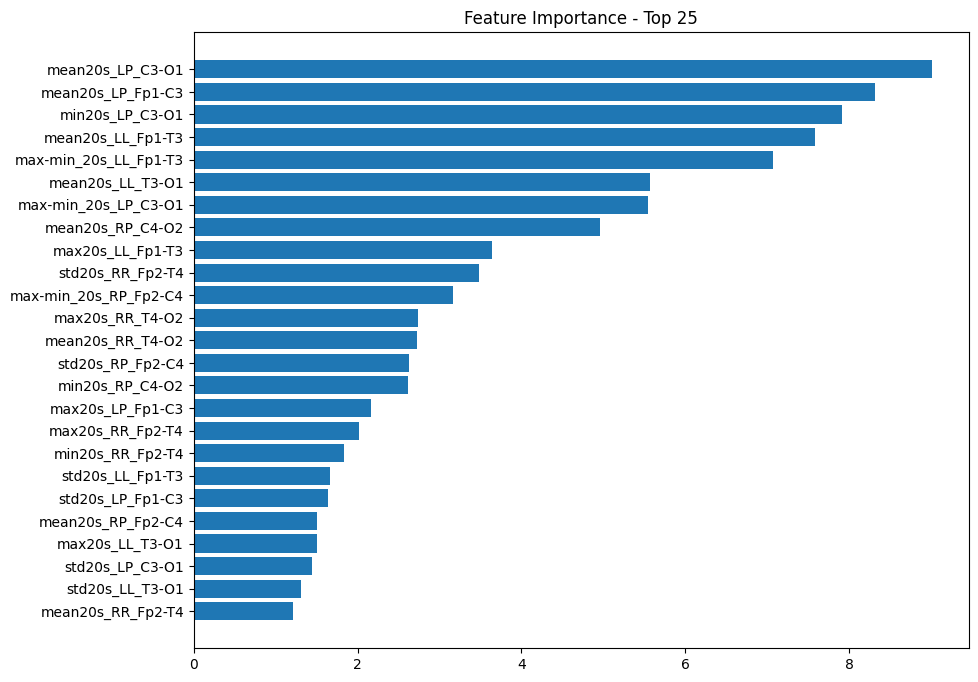

In [13]:
TOP = 25

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 8))
plt.barh(np.arange(len(sorted_idx))[-TOP:], feature_importance[sorted_idx][-TOP:], align='center')
plt.yticks(np.arange(len(sorted_idx))[-TOP:], np.array(FEATURES)[sorted_idx][-TOP:])
plt.title(f'Feature Importance - Top {TOP}')
plt.show()

# CV Score for CatBoost
This is CV score for our CatBoost model.

In [14]:
import sys
sys.path.append('../input/hms-harmful-brain-activity-classification//kaggle-kl-div')
from kaggle_kl_div import score

oof = pd.DataFrame(all_oof.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

oof.head()

,0,1,2,3,4,5,id
0,0.631495,0.048162,0.139441,0.026195,0.043139,0.111568,0
1,0.555283,0.056674,0.183169,0.030442,0.052920,0.121511,1
2,0.564555,0.059569,0.174324,0.029979,0.048143,0.123430,2
3,0.162066,0.137875,0.083902,0.170899,0.175755,0.269504,3
4,0.138935,0.242624,0.149119,0.081558,0.155119,0.232644,4


In [15]:
true.head()

,0,1,2,3,4,5,id
0,0.6,0.0,0.4,0.0,0.0,0.0,0
1,0.6,0.0,0.4,0.0,0.0,0.0,1
2,0.6,0.0,0.4,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,1.0,3
4,0.0,0.0,0.8,0.0,0.0,0.2,4


In [16]:
# TARGETSの各列を正規化
oof_data = oof[[0, 1, 2, 3, 4, 5]].values
oof_data = oof_data / oof_data.sum(axis=1,keepdims=True)
oof[[0, 1, 2, 3, 4, 5]] = oof_data

In [17]:
oof.head()

,0,1,2,3,4,5,id
0,0.631495,0.048162,0.139441,0.026195,0.043139,0.111568,0
1,0.555283,0.056674,0.183169,0.030442,0.052920,0.121511,1
2,0.564555,0.059569,0.174324,0.029979,0.048143,0.123430,2
3,0.162066,0.137875,0.083902,0.170899,0.175755,0.269504,3
4,0.138935,0.242624,0.149119,0.081558,0.155119,0.232644,4


In [18]:
temp = pl.from_pandas(oof)

In [19]:
cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score KL-Div for CatBoost =',cv)


CV Score KL-Div for CatBoost = 1.3284998924465632


In [20]:
import sys
sys.path.append('../input/hms-harmful-brain-activity-classification//kaggle-kl-div')
from kaggle_kl_div import score

oof = pd.DataFrame(all_oof.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score KL-Div for CatBoost =',cv)

# CV Score KL-Divの保存
with open(f'../model/CV_Score_v{VER}.txt', 'w') as f:
    f.write(str(cv) + "\n")

CV Score KL-Div for CatBoost = 1.3284998924465632


# CV Score for Preds 1/6
This is CV score for Kaggle's sample submission.csv which uses equal predictions of 1/6 for all targets.

各目的変数の重みをすべて 1/6 にしたときのCVスコア

In [21]:
oof = pd.DataFrame(all_oof.copy())
for c in oof.columns:
    oof[c] = 1/6.
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score for "Use Equal Preds 1/6" =',cv)

# CV Score for "Use Equal Preds 1/6"の保存
with open(f'../model/CV_Score_USE_EQUAL_PREDS_v{VER}.txt', 'w') as f:
    f.write(str(cv) + "\n")

CV Score for "Use Equal Preds 1/6" = 1.4120945699192327


# CV Score for EEG_Id Means
This is CV score for current highest scoring public notebook [here][1] which uses train means as predictions.

学習データのmeanを用いたCVスコア

[1]: https://www.kaggle.com/code/seshurajup/eda-train-csv

In [22]:
all_oof2 = []

gkf = GroupKFold(n_splits=5)
for i, (train_index, valid_index) in enumerate(gkf.split(df_train, df_train.target, df_train.patient_id)):  
    #print('#'*25)
    #print(f'### Fold {i+1}')
        
    y_train = df_train.iloc[train_index][TARGETS].values
    y_valid = df_train.iloc[valid_index][TARGETS].values
    
    #print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    #print('#'*25)
        
    oof = y_valid.copy()
    for j in range(6):
        oof[:,j] = y_train[:,j].mean()
    oof = oof / oof.sum(axis=1,keepdims=True)
    all_oof2.append(oof)
    
all_oof2 = np.concatenate(all_oof2)

In [23]:
oof = pd.DataFrame(all_oof2.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score for "Use Train Means" =',cv)

# CV Score for "Use Equal Preds 1/6"の保存
with open(f'../model/CV_Score_EEG_ID_MEANS_v{VER}.txt', 'w') as f:
    f.write(str(cv) + "\n")

CV Score for "Use Train Means" = 1.4007202810801358
